In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [3]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2284015 entries, 0 to 2284014
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 34.9 MB


# reduce to 1 million events

In [4]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [5]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,26475,0.14,26.475
1,26651,0.14,26.651
2,26802,0.13,26.802
3,27102,0.13,27.102
4,26822,0.13,26.822
...,...,...,...
999995,26508,0.14,26.508
999996,26273,0.14,26.273
999997,26405,0.14,26.405
999998,27874,0.13,27.874


### conversion Interval -> kWh

In [6]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,26475,0.14,26.475,135.977337
1,26651,0.14,26.651,135.079359
2,26802,0.13,26.802,134.318334
3,27102,0.13,27.102,132.831525
4,26822,0.13,26.822,134.218179
...,...,...,...,...
999995,26508,0.14,26.508,135.808058
999996,26273,0.14,26.273,137.022799
999997,26405,0.14,26.405,136.337815
999998,27874,0.13,27.874,129.152615


### Cumul Total interval

In [7]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [8]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26097473163000

### Calcul de la date de base = now - cumul_interval

In [9]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 8, 6, 20, 20, 56, 675752)

In [10]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [11]:
conso_data.iloc[0]


Interval     26475.000000
kWh              0.140000
sec             26.475000
Wh             135.977337
cumul(ms)    26475.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [12]:
base

datetime.datetime(2024, 8, 6, 20, 20, 56, 675752)

## créer les dates

In [13]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-08-06 20:21:23.150752
1        2024-08-06 20:21:49.801752
2        2024-08-06 20:22:16.603752
3        2024-08-06 20:22:43.705752
4        2024-08-06 20:23:10.527752
                    ...            
999995   2025-06-04 21:37:02.756752
999996   2025-06-04 21:37:29.029752
999997   2025-06-04 21:37:55.434752
999998   2025-06-04 21:38:23.308752
999999   2025-06-04 21:38:49.838752
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [14]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,26475,0.14,26.475,135.977337,26475,2024-08-06 20:21:23.150752,06/08/24
1,26651,0.14,26.651,135.079359,53126,2024-08-06 20:21:49.801752,06/08/24
2,26802,0.13,26.802,134.318334,79928,2024-08-06 20:22:16.603752,06/08/24
3,27102,0.13,27.102,132.831525,107030,2024-08-06 20:22:43.705752,06/08/24
4,26822,0.13,26.822,134.218179,133852,2024-08-06 20:23:10.527752,06/08/24
...,...,...,...,...,...,...,...
999995,26508,0.14,26.508,135.808058,26097366081,2025-06-04 21:37:02.756752,04/06/25
999996,26273,0.14,26.273,137.022799,26097392354,2025-06-04 21:37:29.029752,04/06/25
999997,26405,0.14,26.405,136.337815,26097418759,2025-06-04 21:37:55.434752,04/06/25
999998,27874,0.13,27.874,129.152615,26097446633,2025-06-04 21:38:23.308752,04/06/25


### save conso_data with dates

In [15]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [16]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('04/06/25', 4, 6, 2025, '21:39:07')

In [17]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [18]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3246 entries, 996754 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3246 non-null   int64         
 1   kWh        3246 non-null   float64       
 2   sec        3246 non-null   float64       
 3   Wh         3246 non-null   float64       
 4   cumul(ms)  3246 non-null   int64         
 5   dates      3246 non-null   datetime64[ns]
 6   days       3246 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 202.9+ KB


In [19]:
end = time.time()
print(end - start)

33.65034627914429


### grouped by days

In [20]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [21]:
data = list(df_grp['kWh'])
print(data)

[0.584, 3.499, 3.691, 3.721, 3.913, 3.654, 4.368, 4.325, 3.911, 3.864, 4.046, 3.777, 3.883, 3.703, 3.274, 3.927, 3.941, 4.381, 3.841, 4.103, 3.8, 3.976, 3.746, 3.994, 3.649, 3.659, 3.5, 3.682, 3.497, 4.153, 3.702, 3.459, 3.556, 3.223, 2.49, 1.796, 1.793, 1.793, 1.795, 2.467, 1.871, 1.788, 1.792, 1.79, 1.82, 1.822, 1.815, 1.817, 1.818, 1.818, 1.815, 1.814, 1.785, 1.786, 1.785, 1.787, 1.782, 1.797, 1.788, 1.79, 1.785, 1.795, 1.803, 1.795, 1.803, 1.796, 1.785, 1.789, 1.786, 1.79, 1.798, 1.79, 1.801, 1.803, 1.795, 1.8, 1.798, 2.763, 4.0, 3.665, 3.889, 3.109, 3.515, 4.061, 3.419, 3.389, 3.982, 3.339, 4.167, 3.094, 4.029, 3.158, 3.344, 3.464, 4.023, 3.287, 3.374, 3.824, 3.227, 3.529, 3.354, 3.869, 3.326, 3.455, 3.711, 4.452, 3.639, 3.864, 3.438, 4.116, 3.488, 3.416, 3.332, 3.848, 3.702, 4.1, 3.537, 3.468, 3.707, 3.173, 3.677, 3.745, 3.319, 3.857, 3.228, 4.065, 3.388, 3.828, 3.991, 3.473, 4.476, 3.212, 3.524, 3.062, 3.251, 3.532, 3.267, 3.356, 3.492, 4.728, 4.359, 3.259, 3.491, 3.691, 3.988, 

In [22]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [23]:
end = time.time()
print(end - start)

38.84772205352783


### plot function by day
#### show('dd/mm/yy')

In [24]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


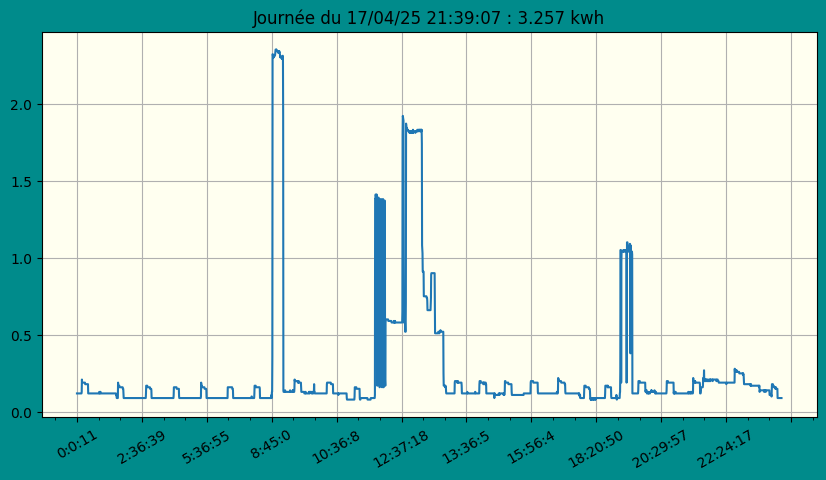

In [25]:
show('17/04/25')

In [26]:
end = time.time()
print(end - start)

42.991029262542725


### 1 kWh window in data of one day
#### df = conso_day

In [27]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
996754,29656,0.12,29.656,121.391961,26019552983,2025-06-04 00:00:09.658752,04/06/25
996755,29563,0.12,29.563,121.773839,26019582546,2025-06-04 00:00:39.221752,04/06/25
996756,28691,0.12,28.691,125.474888,26019611237,2025-06-04 00:01:07.912752,04/06/25
996757,29001,0.12,29.001,124.133651,26019640238,2025-06-04 00:01:36.913752,04/06/25
996758,27679,0.13,27.679,130.062502,26019667917,2025-06-04 00:02:04.592752,04/06/25
...,...,...,...,...,...,...,...
999995,26508,0.14,26.508,135.808058,26097366081,2025-06-04 21:37:02.756752,04/06/25
999996,26273,0.14,26.273,137.022799,26097392354,2025-06-04 21:37:29.029752,04/06/25
999997,26405,0.14,26.405,136.337815,26097418759,2025-06-04 21:37:55.434752,04/06/25
999998,27874,0.13,27.874,129.152615,26097446633,2025-06-04 21:38:23.308752,04/06/25


In [28]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [29]:
df = conso_day
len(df)

3246

In [30]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-06-04 00:00:09.658752	2025-06-04 09:04:38.697752	9h 4m 29s 	1000
2025-06-04 09:04:38.697752	2025-06-04 13:39:16.359752	4h 34m 37s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.304954
dtype: float64

In [32]:
end = time.time()
print(end - start)

47.95633053779602


## mean for data grouped by days

In [33]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [34]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(3.246)

# conso by date


In [35]:
# select day
day = today

#day = '16/08/24'
day

'04/06/25'

In [36]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
996754,29656,0.12,29.656,121.391961,26019552983,2025-06-04 00:00:09.658752,04/06/25
996755,29563,0.12,29.563,121.773839,26019582546,2025-06-04 00:00:39.221752,04/06/25
996756,28691,0.12,28.691,125.474888,26019611237,2025-06-04 00:01:07.912752,04/06/25
996757,29001,0.12,29.001,124.133651,26019640238,2025-06-04 00:01:36.913752,04/06/25
996758,27679,0.13,27.679,130.062502,26019667917,2025-06-04 00:02:04.592752,04/06/25
...,...,...,...,...,...,...,...
999995,26508,0.14,26.508,135.808058,26097366081,2025-06-04 21:37:02.756752,04/06/25
999996,26273,0.14,26.273,137.022799,26097392354,2025-06-04 21:37:29.029752,04/06/25
999997,26405,0.14,26.405,136.337815,26097418759,2025-06-04 21:37:55.434752,04/06/25
999998,27874,0.13,27.874,129.152615,26097446633,2025-06-04 21:38:23.308752,04/06/25


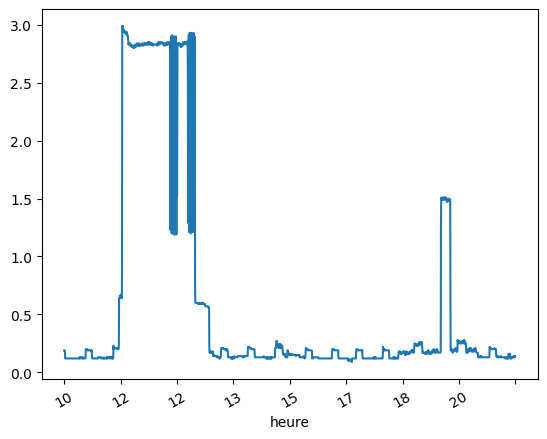

In [37]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [38]:
end = time.time()
print(end - start)

49.558947801589966


### grouped by 'heure'

In [39]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3246 entries, 996754 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3246 non-null   int64         
 1   kWh        3246 non-null   float64       
 2   sec        3246 non-null   float64       
 3   Wh         3246 non-null   float64       
 4   cumul(ms)  3246 non-null   int64         
 5   dates      3246 non-null   datetime64[ns]
 6   days       3246 non-null   object        
 7   heure      3246 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 228.2+ KB


In [40]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
996754,29656,0.12,29.656,121.391961,26019552983,2025-06-04 00:00:09.658752,04/06/25
996755,29563,0.12,29.563,121.773839,26019582546,2025-06-04 00:00:39.221752,04/06/25
996756,28691,0.12,28.691,125.474888,26019611237,2025-06-04 00:01:07.912752,04/06/25
996757,29001,0.12,29.001,124.133651,26019640238,2025-06-04 00:01:36.913752,04/06/25
996758,27679,0.13,27.679,130.062502,26019667917,2025-06-04 00:02:04.592752,04/06/25
...,...,...,...,...,...,...,...
999995,26508,0.14,26.508,135.808058,26097366081,2025-06-04 21:37:02.756752,04/06/25
999996,26273,0.14,26.273,137.022799,26097392354,2025-06-04 21:37:29.029752,04/06/25
999997,26405,0.14,26.405,136.337815,26097418759,2025-06-04 21:37:55.434752,04/06/25
999998,27874,0.13,27.874,129.152615,26097446633,2025-06-04 21:38:23.308752,04/06/25


In [41]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [42]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     129
1     106
2     101
3     101
4     101
5     100
6     100
7      98
8     153
9     143
10    130
11    132
12    508
13    145
14    148
15    157
16    132
17    129
18    142
19    224
20    179
21     88
Name: kWh, dtype: int64

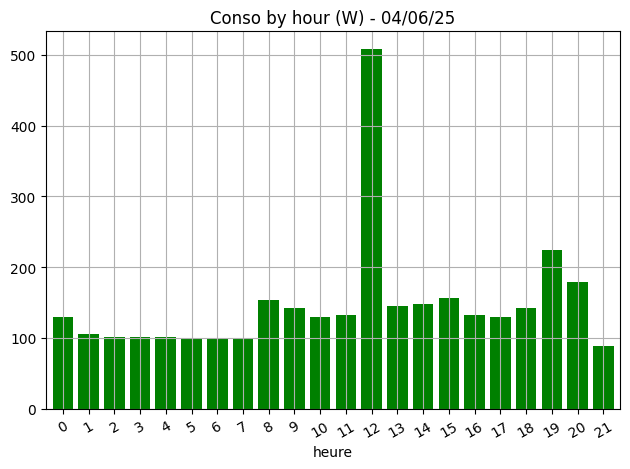

In [43]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [44]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 06/08/24 to 04/06/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [45]:
# give the periods of 1 kwh in a day
period()

2025-06-04 00:00:09.658752	2025-06-04 09:04:38.697752	9h 4m 29s 	1000


In [46]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [47]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [48]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [49]:
df_grp.head()


,kWh
days,
06/08/24,0.584
07/08/24,3.499
08/08/24,3.691
09/08/24,3.721
10/08/24,3.913


In [50]:
df_grp.tail()


,kWh
days,
31/05/25,2.667
01/06/25,3.413
02/06/25,3.037
03/06/25,3.084
04/06/25,3.246


In [51]:
end = time.time()
print(end - start)

52.681278467178345


# plot les 100 derniers jours


In [52]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.33031
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

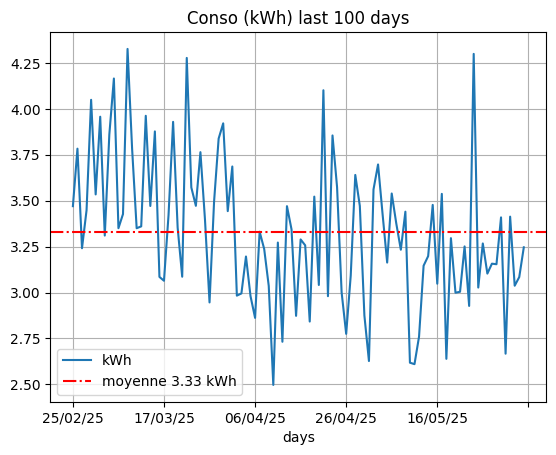

In [53]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [54]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.497
max,4.326


In [55]:
end = time.time()
print(end - start)

53.99531865119934


In [56]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('05/05/25', '30/05/25')

In [57]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.1626
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

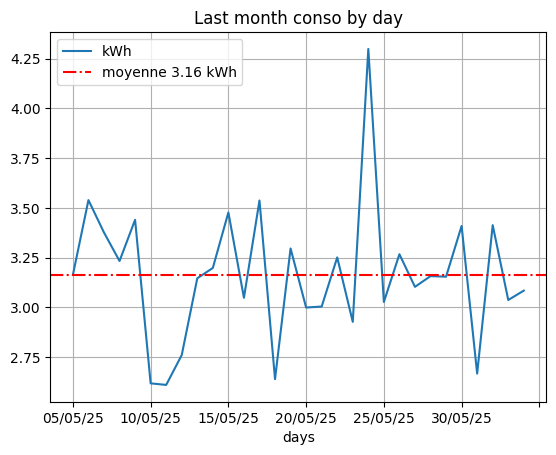

In [58]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [59]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 24/05/25 4.299
Min : 11/05/25 2.61


# Temps de conso par tranche de 1 kWh

In [60]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


4
2025-06-04 00:00:09.658752	2025-06-04 09:04:38.697752	9h 4m 29s 	1000
2025-06-04 09:04:38.697752	2025-06-04 13:39:16.359752	4h 34m 37s 	2000
2025-06-04 13:39:16.359752	2025-06-04 20:05:35.789752	6h 26m 19s 	3000
2025-06-04 20:05:35.789752	2025-06-04 21:38:49.838752	1h 33m 14s 	246


In [61]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('21:39:07', 3.246, 3246)

In [62]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3246 entries, 996754 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3246 non-null   int64         
 1   kWh        3246 non-null   float64       
 2   sec        3246 non-null   float64       
 3   Wh         3246 non-null   float64       
 4   cumul(ms)  3246 non-null   int64         
 5   dates      3246 non-null   datetime64[ns]
 6   days       3246 non-null   object        
 7   heure      3246 non-null   object        
 8   hours      3246 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 253.6+ KB


In [63]:
conso_hours['heure'], conso_hours['hours']

(996754     0
 996755     0
 996756     0
 996757     0
 996758     0
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: heure, Length: 3246, dtype: object,
 996754    00
 996755    00
 996756    00
 996757    00
 996758    00
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: hours, Length: 3246, dtype: object)

In [64]:
end = time.time()
print(end - start)

54.88831615447998


# select number of days to display


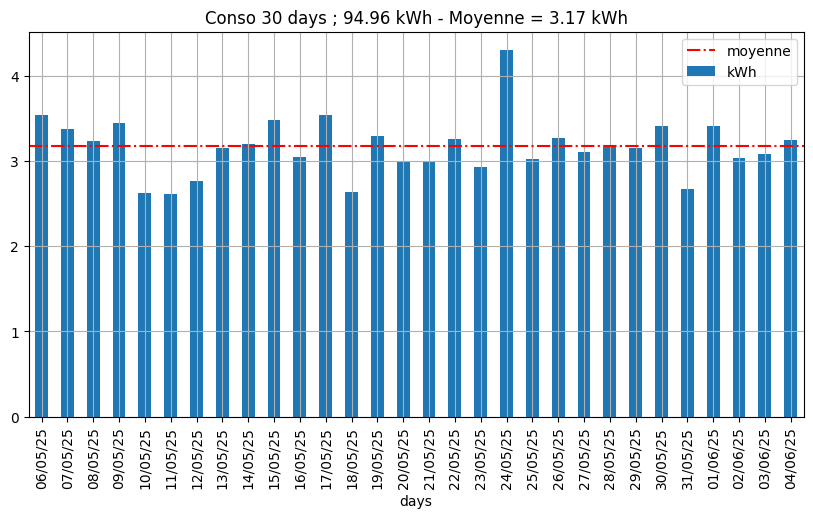

In [65]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


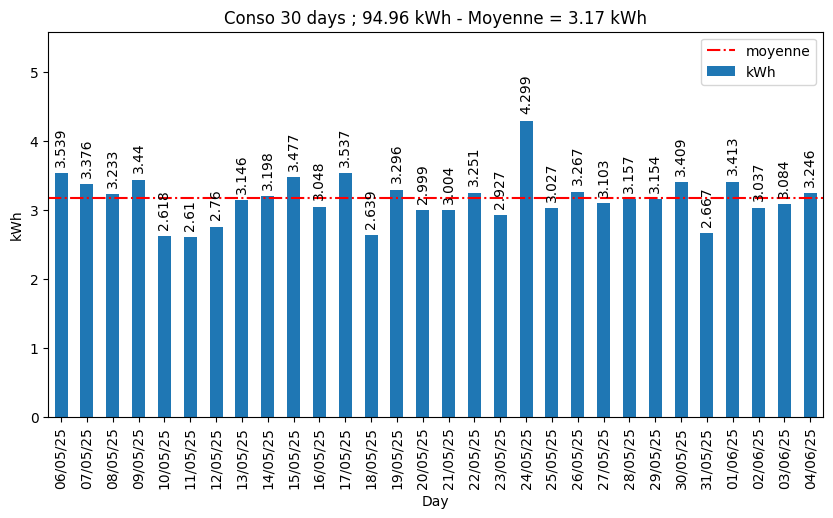

In [66]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [67]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
06/05/25    3.539
07/05/25    3.376
08/05/25    3.233
09/05/25    3.440
10/05/25    2.618
11/05/25    2.610
12/05/25    2.760
13/05/25    3.146
14/05/25    3.198
15/05/25    3.477
16/05/25    3.048
17/05/25    3.537
18/05/25    2.639
19/05/25    3.296
20/05/25    2.999
21/05/25    3.004
22/05/25    3.251
23/05/25    2.927
24/05/25    4.299
25/05/25    3.027
26/05/25    3.267
27/05/25    3.103
28/05/25    3.157
29/05/25    3.154
30/05/25    3.409
31/05/25    2.667
01/06/25    3.413
02/06/25    3.037
03/06/25    3.084
04/06/25    3.246
Name: kWh, dtype: float64

In [68]:
x_labels=df_grp.tail(span).index
x_labels

Index(['06/05/25', '07/05/25', '08/05/25', '09/05/25', '10/05/25', '11/05/25',
       '12/05/25', '13/05/25', '14/05/25', '15/05/25', '16/05/25', '17/05/25',
       '18/05/25', '19/05/25', '20/05/25', '21/05/25', '22/05/25', '23/05/25',
       '24/05/25', '25/05/25', '26/05/25', '27/05/25', '28/05/25', '29/05/25',
       '30/05/25', '31/05/25', '01/06/25', '02/06/25', '03/06/25', '04/06/25'],
      dtype='object', name='days')

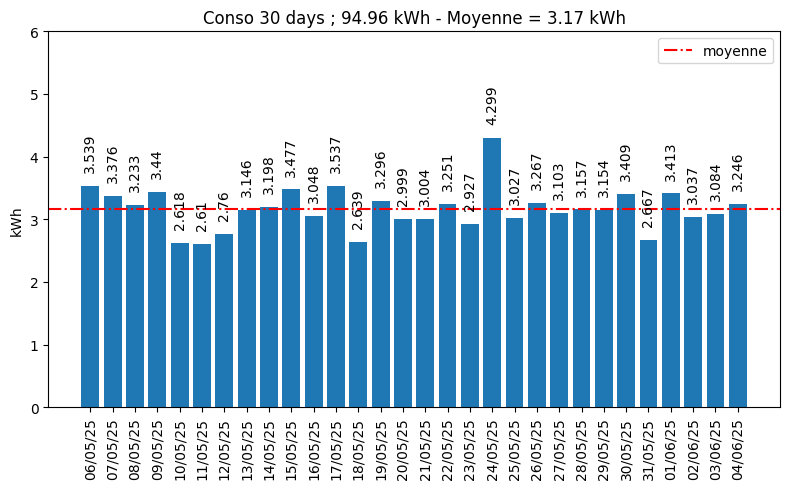

In [69]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [70]:
end = time.time()
print(end - start)

60.28661322593689


In [71]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

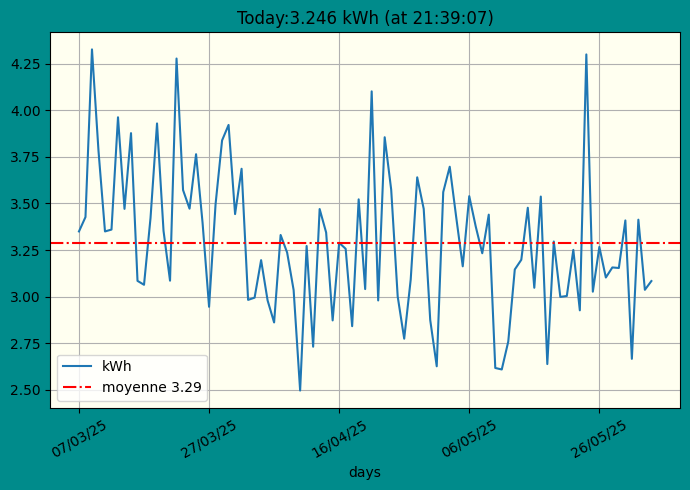

In [72]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

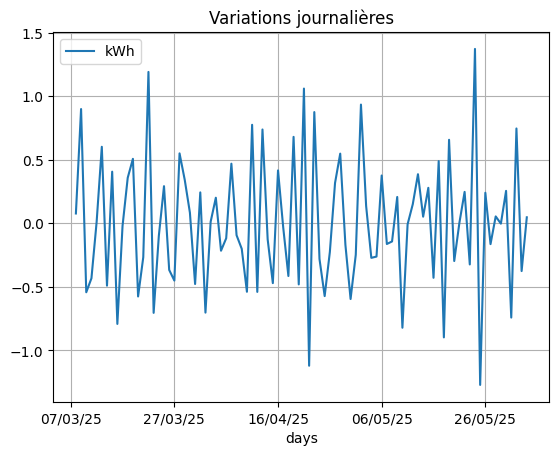

In [73]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [74]:
end = time.time()
print(end - start)

62.94429111480713


# Data from 21/08/23

In [75]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,26475,0.14,26.475,135.977337,26475,2024-08-06 20:21:23.150752,06/08/24,20,2024-08,06
1,26651,0.14,26.651,135.079359,53126,2024-08-06 20:21:49.801752,06/08/24,20,2024-08,06
2,26802,0.13,26.802,134.318334,79928,2024-08-06 20:22:16.603752,06/08/24,20,2024-08,06
3,27102,0.13,27.102,132.831525,107030,2024-08-06 20:22:43.705752,06/08/24,20,2024-08,06
4,26822,0.13,26.822,134.218179,133852,2024-08-06 20:23:10.527752,06/08/24,20,2024-08,06
...,...,...,...,...,...,...,...,...,...,...
999995,26508,0.14,26.508,135.808058,26097366081,2025-06-04 21:37:02.756752,04/06/25,21,2025-06,04
999996,26273,0.14,26.273,137.022799,26097392354,2025-06-04 21:37:29.029752,04/06/25,21,2025-06,04
999997,26405,0.14,26.405,136.337815,26097418759,2025-06-04 21:37:55.434752,04/06/25,21,2025-06,04
999998,27874,0.13,27.874,129.152615,26097446633,2025-06-04 21:38:23.308752,04/06/25,21,2025-06,04


In [76]:
end = time.time()
print(end - start)

103.14426326751709


In [77]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

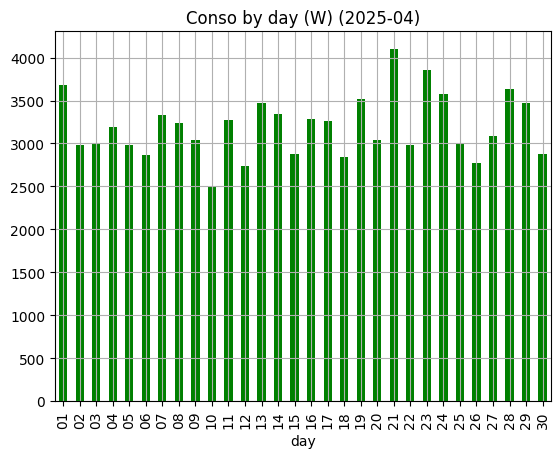

In [78]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [79]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3193.633333333333)

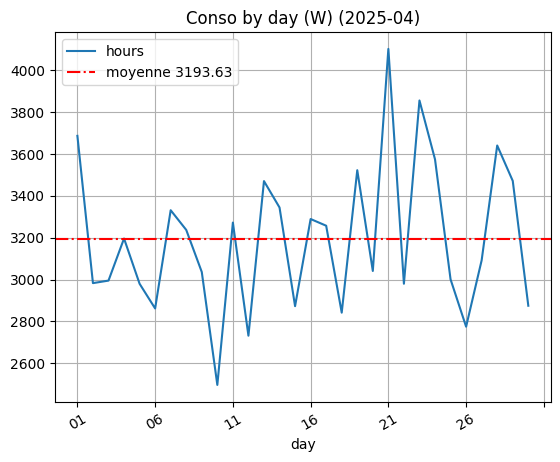

In [80]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [81]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

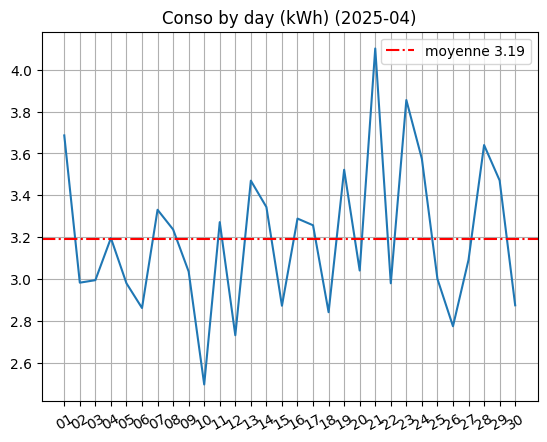

In [82]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [83]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [84]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [85]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-08,97230,97230,97230
2024-09,69829,69829,69829
2024-10,73461,73461,73461
2024-11,108506,108506,108506
2024-12,113716,113716,113716
2025-01,113715,113715,113715
2025-02,104454,104454,104454
2025-03,111846,111846,111846
2025-04,95809,95809,95809


In [86]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [87]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [88]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
06/08/24,584
07/08/24,3499
08/08/24,3691
09/08/24,3721
10/08/24,3913
...,...
31/05/25,2667
01/06/25,3413
02/06/25,3037


In [89]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,26475,0.14,26.475,135.977337,26475,2024-08-06 20:21:23.150752,06/08/24,20,2024-08,06
1,26651,0.14,26.651,135.079359,53126,2024-08-06 20:21:49.801752,06/08/24,20,2024-08,06
2,26802,0.13,26.802,134.318334,79928,2024-08-06 20:22:16.603752,06/08/24,20,2024-08,06
3,27102,0.13,27.102,132.831525,107030,2024-08-06 20:22:43.705752,06/08/24,20,2024-08,06
4,26822,0.13,26.822,134.218179,133852,2024-08-06 20:23:10.527752,06/08/24,20,2024-08,06
...,...,...,...,...,...,...,...,...,...,...
999995,26508,0.14,26.508,135.808058,26097366081,2025-06-04 21:37:02.756752,04/06/25,21,2025-06,04
999996,26273,0.14,26.273,137.022799,26097392354,2025-06-04 21:37:29.029752,04/06/25,21,2025-06,04
999997,26405,0.14,26.405,136.337815,26097418759,2025-06-04 21:37:55.434752,04/06/25,21,2025-06,04
999998,27874,0.13,27.874,129.152615,26097446633,2025-06-04 21:38:23.308752,04/06/25,21,2025-06,04


In [90]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
06/08/24 20    0       06/08/24    20  0.14
               1       06/08/24    20  0.14
               2       06/08/24    20  0.13
               3       06/08/24    20  0.13
               4       06/08/24    20  0.13
...                         ...   ...   ...
04/06/25 21    999995  04/06/25    21  0.14
               999996  04/06/25    21  0.14
               999997  04/06/25    21  0.14
               999998  04/06/25    21  0.13
               999999  04/06/25    21  0.14

[1000000 rows x 3 columns]

In [91]:
groupallbyday.indices.keys()

dict_keys(['06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/1

In [92]:
groupallbydayhours.indices.keys()

dict_keys([('06/08/24', '20'), ('06/08/24', '21'), ('06/08/24', '22'), ('06/08/24', '23'), ('07/08/24', '20'), ('07/08/24', '21'), ('07/08/24', '22'), ('07/08/24', '23'), ('07/08/24', '00'), ('07/08/24', '01'), ('07/08/24', '02'), ('07/08/24', '03'), ('07/08/24', '04'), ('07/08/24', '05'), ('07/08/24', '06'), ('07/08/24', '07'), ('07/08/24', '08'), ('07/08/24', '09'), ('07/08/24', '10'), ('07/08/24', '11'), ('07/08/24', '12'), ('07/08/24', '13'), ('07/08/24', '14'), ('07/08/24', '15'), ('07/08/24', '16'), ('07/08/24', '17'), ('07/08/24', '18'), ('07/08/24', '19'), ('08/08/24', '20'), ('08/08/24', '21'), ('08/08/24', '22'), ('08/08/24', '23'), ('08/08/24', '00'), ('08/08/24', '01'), ('08/08/24', '02'), ('08/08/24', '03'), ('08/08/24', '04'), ('08/08/24', '05'), ('08/08/24', '06'), ('08/08/24', '07'), ('08/08/24', '08'), ('08/08/24', '09'), ('08/08/24', '10'), ('08/08/24', '11'), ('08/08/24', '12'), ('08/08/24', '13'), ('08/08/24', '14'), ('08/08/24', '15'), ('08/08/24', '16'), ('08/08/2

In [93]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
06/08/24,584,584
07/08/24,3499,3499
08/08/24,3691,3691
09/08/24,3721,3721
10/08/24,3913,3913
...,...,...
31/05/25,2667,2667
01/06/25,3413,3413
02/06/25,3037,3037


In [94]:
grp_by_day['kWh'].cumsum()

days
06/08/24        584
07/08/24       4083
08/08/24       7774
09/08/24      11495
10/08/24      15408
             ...   
31/05/25     987220
01/06/25     990633
02/06/25     993670
03/06/25     996754
04/06/25    1000000
Name: kWh, Length: 303, dtype: int64

In [95]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
06/08/24 20     101
         21     147
         22     157
         23     179
07/08/24 00     162
...             ...
04/06/25 17     129
         18     142
         19     224
         20     179
         21      88

[7250 rows x 1 columns]

In [96]:
grp_by_dayhours['kWh'].cumsum()

days      hours
06/08/24  20           101
          21           248
          22           405
          23           584
07/08/24  00           746
                    ...   
04/06/25  17        999367
          18        999509
          19        999733
          20        999912
          21       1000000
Name: kWh, Length: 7250, dtype: int64

In [97]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
06/08/24 20     101     101   NaN
         21     147     248  46.0
         22     157     405  10.0
         23     179     584  22.0
07/08/24 00     162     162   NaN
...             ...     ...   ...
04/06/25 17     129    2613  -3.0
         18     142    2755  13.0
         19     224    2979  82.0
         20     179    3158 -45.0
         21      88    3246 -91.0

[7250 rows x 3 columns]

In [98]:
today, grp_by_dayhours.loc[today]

('04/06/25',
        kWh  cumsum   diff
 hours                    
 00     129     129    NaN
 01     106     235  -23.0
 02     101     336   -5.0
 03     101     437    0.0
 04     101     538    0.0
 05     100     638   -1.0
 06     100     738    0.0
 07      98     836   -2.0
 08     153     989   55.0
 09     143    1132  -10.0
 10     130    1262  -13.0
 11     132    1394    2.0
 12     508    1902  376.0
 13     145    2047 -363.0
 14     148    2195    3.0
 15     157    2352    9.0
 16     132    2484  -25.0
 17     129    2613   -3.0
 18     142    2755   13.0
 19     224    2979   82.0
 20     179    3158  -45.0
 21      88    3246  -91.0)

Text(0.5, 1.0, 'Cumul journalier')

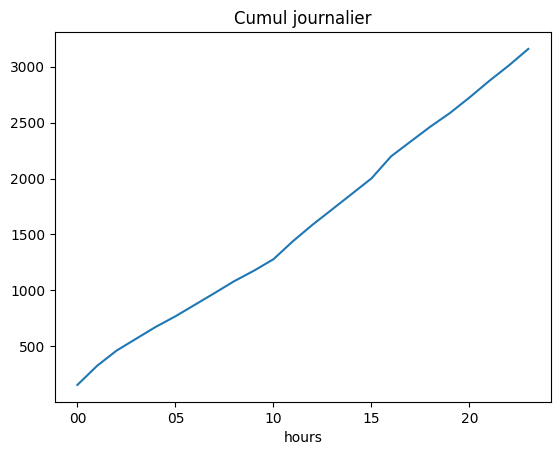

In [99]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

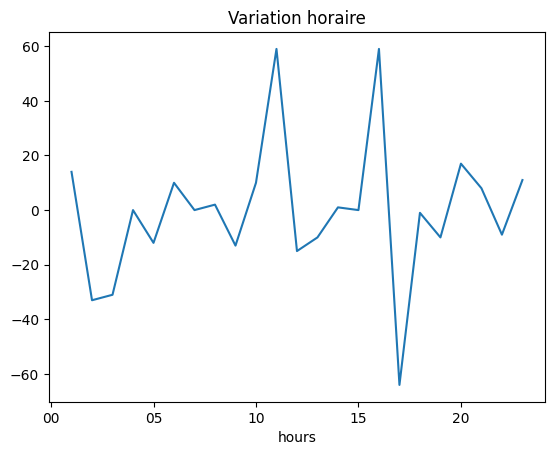

In [100]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [101]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [102]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.741972
min        0.584000
25%        3.074000
50%        3.425000
75%        3.771500
max        4.882000
Name: kWh, dtype: float64

In [103]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [104]:
n, np.nanmean(df_grp.tail(n))

(303, np.float64(3.3003300330033003))

Text(0.5, 1.0, '303 days')

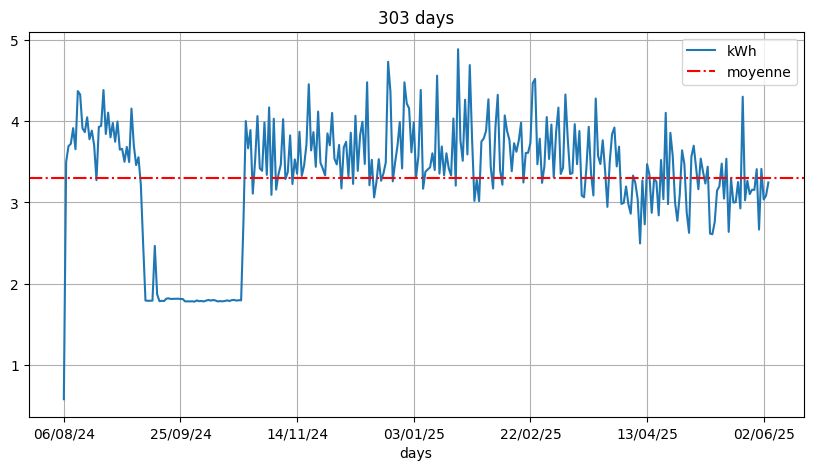

In [105]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

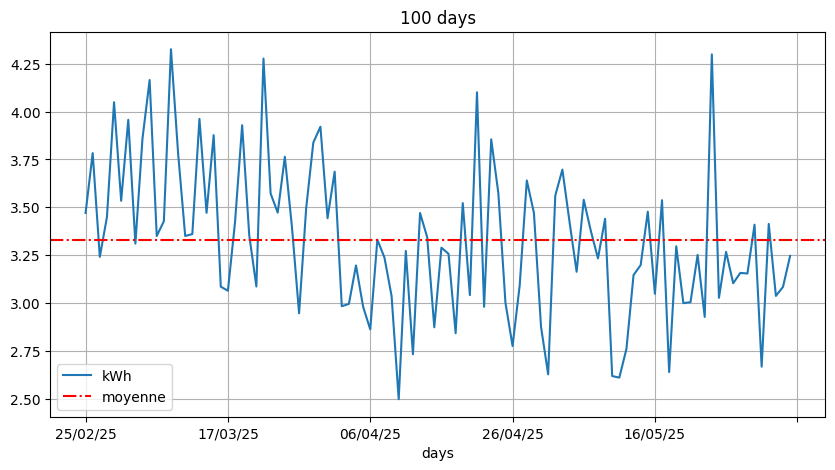

In [106]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [107]:
np.nanmean(df_grp.tail(span))

np.float64(3.33031)

In [108]:
df_grp['kWh']

days
06/08/24    0.584
07/08/24    3.499
08/08/24    3.691
09/08/24    3.721
10/08/24    3.913
            ...  
31/05/25    2.667
01/06/25    3.413
02/06/25    3.037
03/06/25    3.084
04/06/25    3.246
Name: kWh, Length: 303, dtype: float64

In [109]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.741972
min,0.584000
25%,3.074000
50%,3.425000
75%,3.771500
max,4.882000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

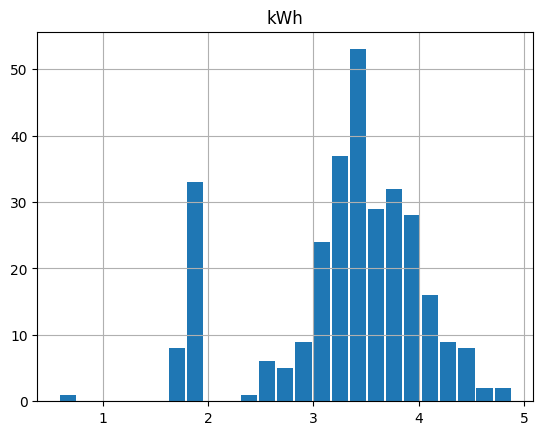

In [110]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [111]:
df_grp.tail(span)['kWh']

days
25/02/25    3.470
26/02/25    3.783
27/02/25    3.241
28/02/25    3.448
01/03/25    4.049
            ...  
31/05/25    2.667
01/06/25    3.413
02/06/25    3.037
03/06/25    3.084
04/06/25    3.246
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [112]:
day

'04/06/25'

In [113]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,129,129,NaN
01,106,235,-23.0
02,101,336,-5.0
03,101,437,0.0
04,101,538,0.0
05,100,638,-1.0
06,100,738,0.0
07,98,836,-2.0
08,153,989,55.0


In [114]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


22

In [115]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 23)

In [116]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [117]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [118]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [119]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [120]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 00 to 21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     22 non-null     int64  
 1   cumsum  22 non-null     int64  
 2   diff    21 non-null     float64
 3   days    22 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 880.0+ bytes


In [121]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [122]:
day

'04/06/25'

In [123]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,129,129,NaN,1.0
01,106,235,-23.0,2.0
02,101,336,-5.0,3.0
03,101,437,0.0,4.0
04,101,538,0.0,5.0
05,100,638,-1.0,6.0
06,100,738,0.0,7.0
07,98,836,-2.0,8.0
08,153,989,55.0,9.0


In [124]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_17636\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(3.2460000000000004)

In [125]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
06/08/24 20     101     101   NaN   NaN
         21     147     248  46.0   NaN
         22     157     405  10.0   NaN
         23     179     584  22.0   NaN
07/08/24 00     162     162   NaN   NaN
...             ...     ...   ...   ...
04/06/25 17     129    2613  -3.0  18.0
         18     142    2755  13.0  19.0
         19     224    2979  82.0  20.0
         20     179    3158 -45.0  21.0
         21      88    3246 -91.0  22.0

[7250 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '04/06/25: kWh    3.246\ndtype: float64')

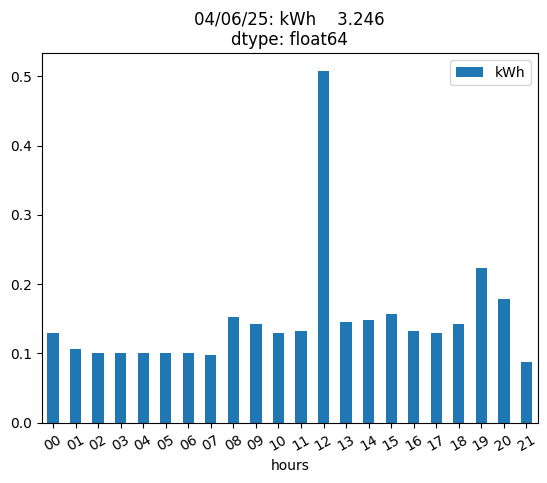

In [126]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [127]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
      dtype='object', name='hours')

# Conso du jour


In [128]:
grp_by_dayhours.count()

kWh       7250
cumsum    7250
diff      6947
days        22
dtype: int64

'22/01/25'

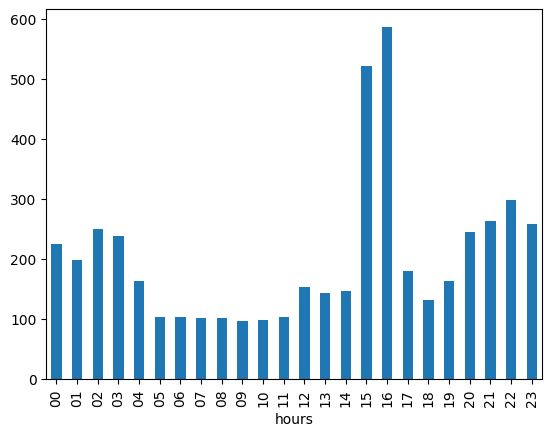

In [129]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [130]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 333.031 , Moyenne= 3.33031


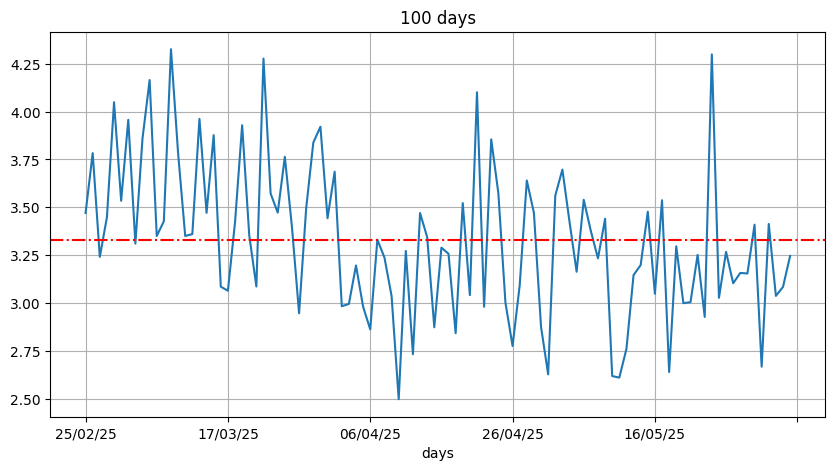

In [131]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [132]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 21:40:42, Minutes in day: 1300


In [133]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [134]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:55.14


In [135]:
end - start

115.13831973075867

In [136]:
#df = conso_day
show_tranches()

4
2025-06-04 00:00:09.658752	2025-06-04 09:04:38.697752	9h 4m 29s 	1000
2025-06-04 09:04:38.697752	2025-06-04 13:39:16.359752	4h 34m 37s 	2000
2025-06-04 13:39:16.359752	2025-06-04 20:05:35.789752	6h 26m 19s 	3000
2025-06-04 20:05:35.789752	2025-06-04 21:38:49.838752	1h 33m 14s 	246


In [137]:
df_grp.tail(7)['kWh']

days
29/05/25    3.154
30/05/25    3.409
31/05/25    2.667
01/06/25    3.413
02/06/25    3.037
03/06/25    3.084
04/06/25    3.246
Name: kWh, dtype: float64

<Axes: xlabel='days'>

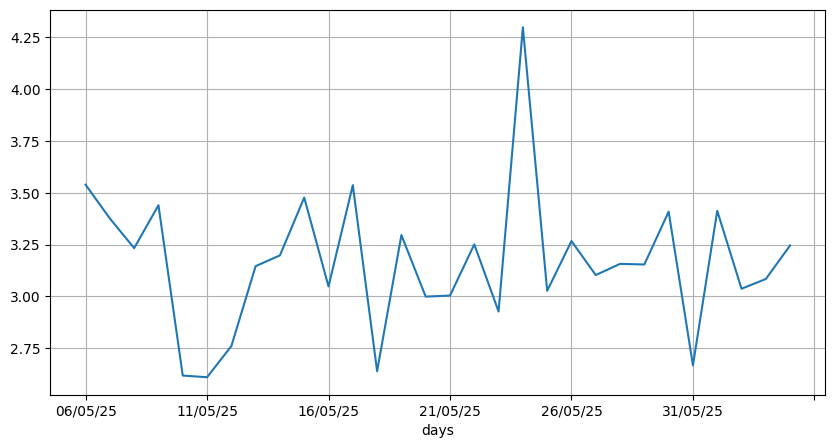

In [138]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)

# Today

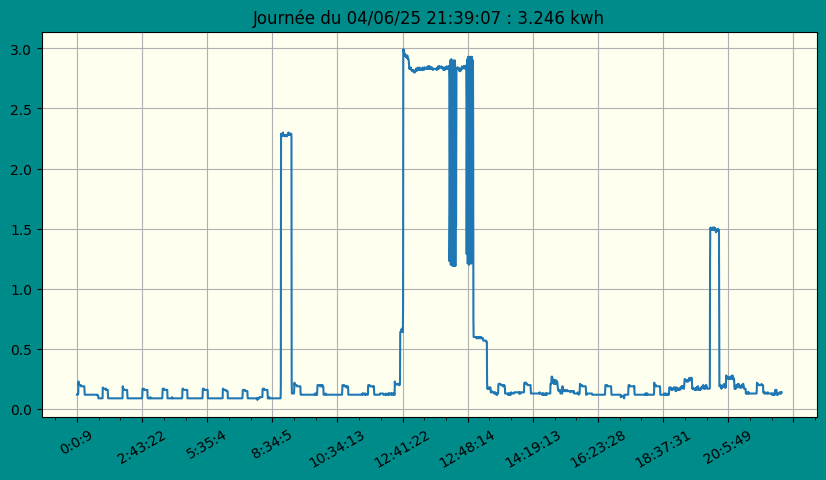

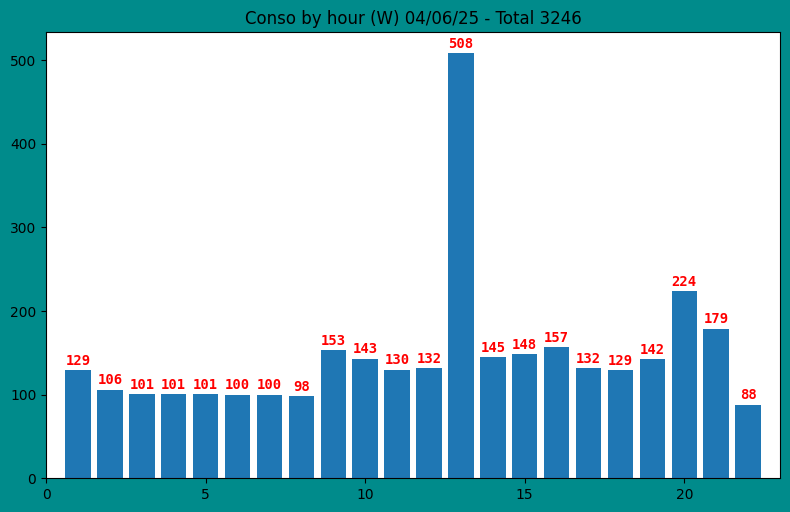

In [139]:
show(today,bgcolor='ivory')
conso_by_hour(today)

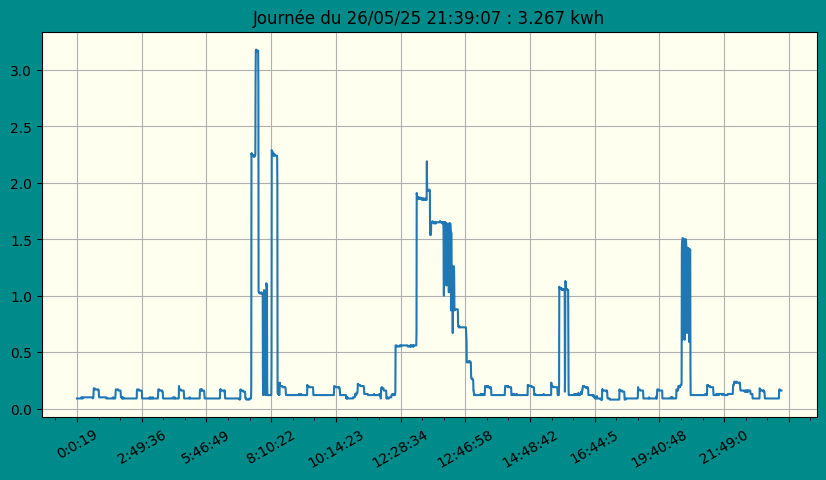

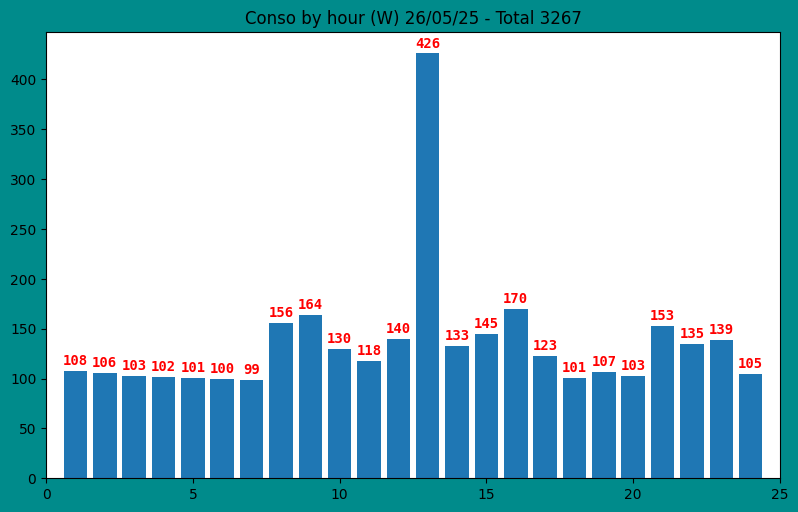

In [140]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4882)

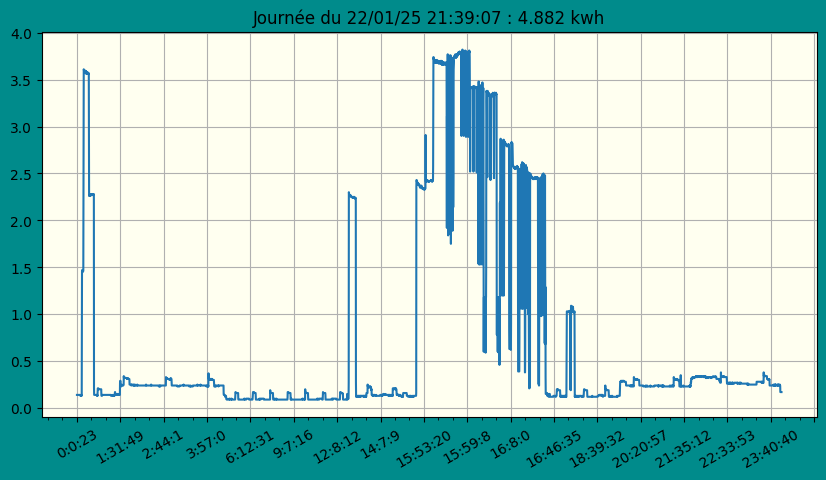

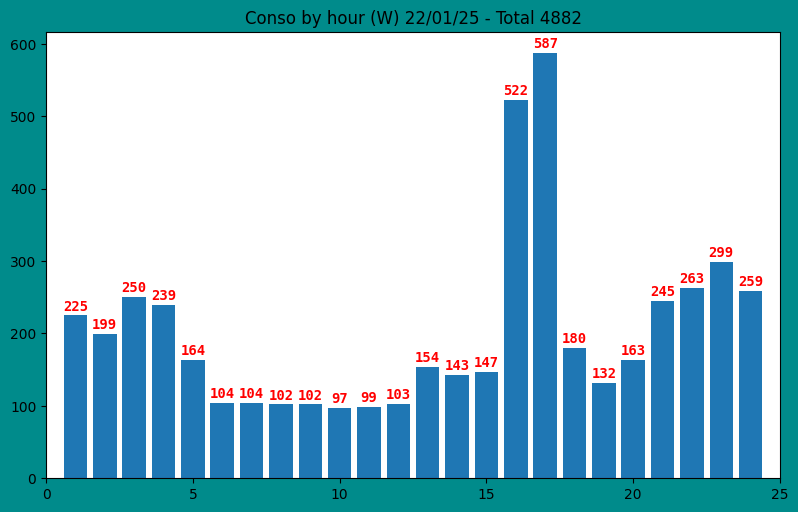

In [141]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

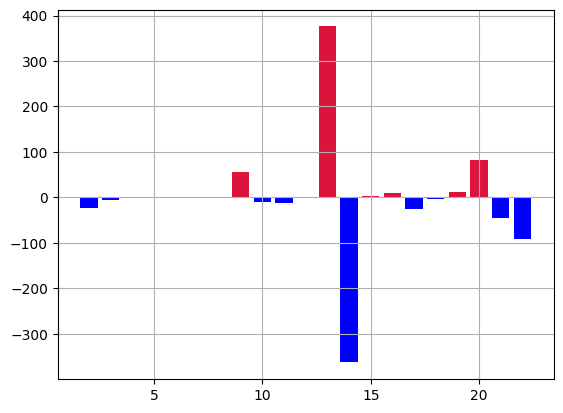

In [142]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

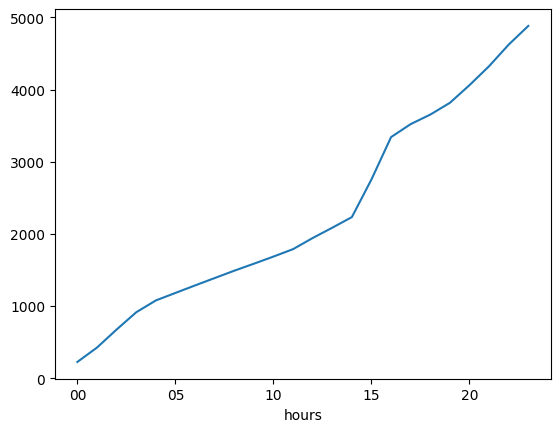

In [143]:
data.cumsum().plot()


<Axes: xlabel='hours'>

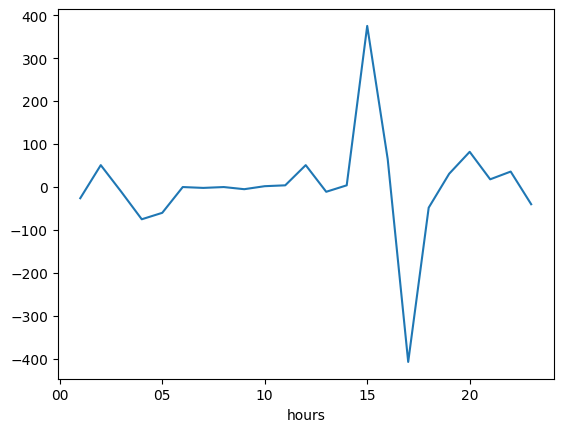

In [144]:
# evolution par heure
data.diff().plot()

In [145]:
data.diff().describe()

count     23.000000
mean       1.478261
std      124.145761
min     -407.000000
25%      -18.500000
50%        0.000000
75%       33.500000
max      375.000000
Name: kWh, dtype: float64

<Axes: >

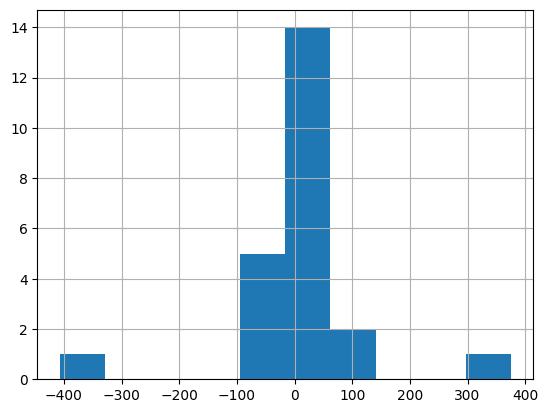

In [146]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [147]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12mi

# list store files csv


In [148]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

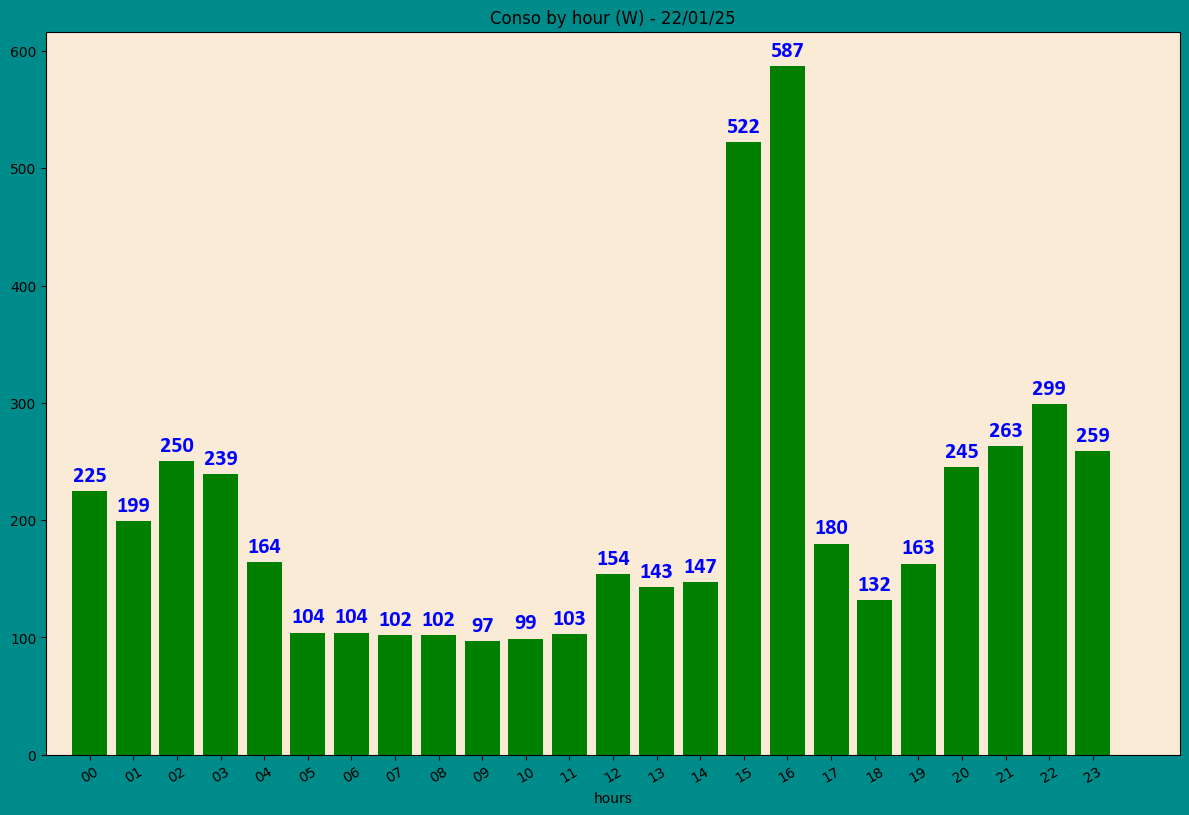

In [149]:
day,conso_byhour(day)

In [150]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


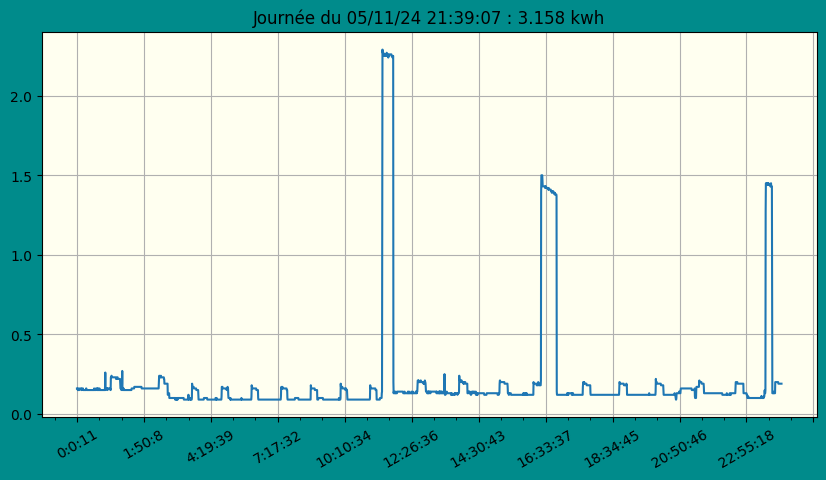

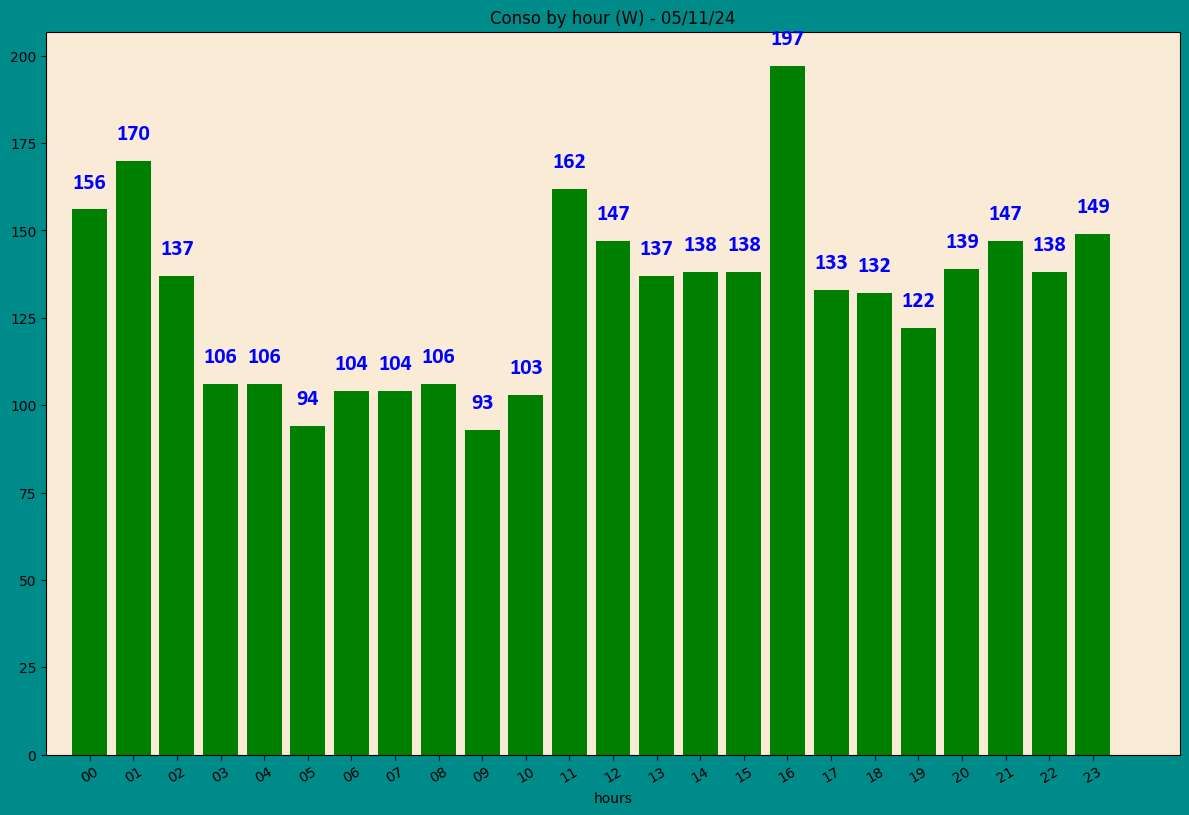

In [151]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [152]:
month

,day,hours,months,kWh
792757,01,00,2025-04,0.20
792758,01,00,2025-04,0.20
792759,01,00,2025-04,0.21
792760,01,00,2025-04,0.21
792761,01,00,2025-04,0.21
...,...,...,...,...
888561,30,23,2025-04,0.09
888562,30,23,2025-04,0.09
888563,30,23,2025-04,0.09
888564,30,23,2025-04,0.09


In [153]:
month.describe()


,kWh
count,95809.000000
mean,0.310158
std,0.547957
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

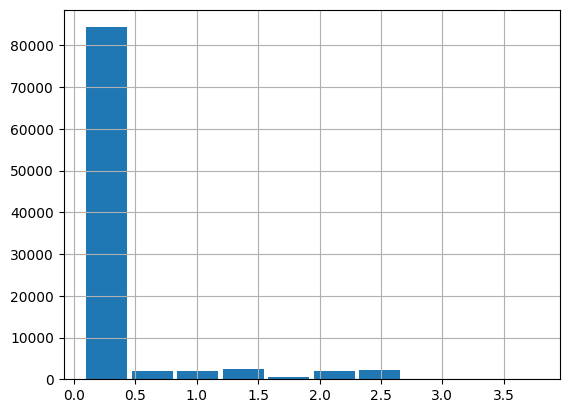

In [154]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

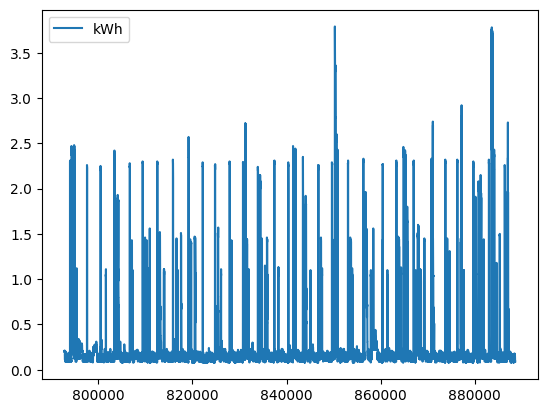

In [155]:
month.plot()

In [156]:
# index with max conso in this month
month.idxmax().kWh

np.int64(850251)

In [157]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       885691
hours     796224
months    792757
kWh       850251
dtype: int64

In [158]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [159]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
06/08/24 20     101     101   NaN   NaN
         21     147     248  46.0   NaN
         22     157     405  10.0   NaN
         23     179     584  22.0   NaN
07/08/24 00     162     162   NaN   NaN
...             ...     ...   ...   ...
04/06/25 17     129    2613  -3.0  18.0
         18     142    2755  13.0  19.0
         19     224    2979  82.0  20.0
         20     179    3158 -45.0  21.0
         21      88    3246 -91.0  22.0

[7250 rows x 4 columns]

In [160]:
month

,day,hours,months,kWh
792757,01,00,2025-04,0.20
792758,01,00,2025-04,0.20
792759,01,00,2025-04,0.21
792760,01,00,2025-04,0.21
792761,01,00,2025-04,0.21
...,...,...,...,...
888561,30,23,2025-04,0.09
888562,30,23,2025-04,0.09
888563,30,23,2025-04,0.09
888564,30,23,2025-04,0.09


In [161]:
month.idxmax()


day       885691
hours     796224
months    792757
kWh       850251
dtype: int64

In [162]:
month.loc[month.idxmax().kWh]


day            19
hours          13
months    2025-04
kWh          3.79
Name: 850251, dtype: object

In [163]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       167
          01       145
          02       114
          03       111
          04        98
          05       111
          06       111
          07       110
          08        98
          09       110
          10       112
          11       189
          12       133
          13       148
          14       145
          15       200
          16       139
          17       192
          18       160
          19       149
          20       142
          21       165
          22       225
          23       174
Name: kWh, dtype: int64

In [164]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

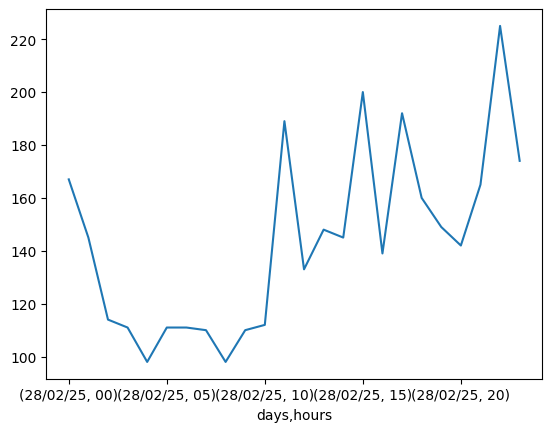

In [165]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [166]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [167]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [168]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [169]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB